In [1]:
# http://blog.yhathq.com/posts/logistic-regression-and-python.html

In [3]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

In [4]:
import sys
sys.path.append('C:\\Users\\dmcdade\\Documents\\Python Scripts\\references')
from base_import import *
%matplotlib inline

from pandasql import *
def pysqldf(q):
    return sqldf(q, globals())

In [5]:
df = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")

In [7]:
df.columns = ["admit", "gre", "gpa", "prestige"]

In [8]:
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002143B240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000216D8898>]], dtype=object)

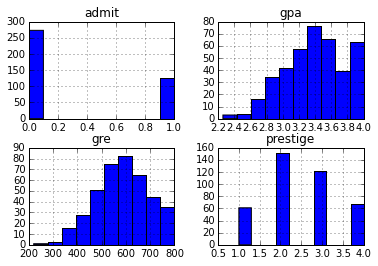

In [9]:
df.hist()

In [10]:
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')

In [11]:
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

In [12]:
train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.589306
         Iterations 5


In [13]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            4
Date:                Mon, 26 Oct 2015   Pseudo R-squ.:                 0.05707
Time:                        14:30:09   Log-Likelihood:                -235.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 9.732e-06
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0014      0.001      1.329      0.184        -0.001     0.003
gpa           -0.1336      0.194     -0.687      0.492        -0.515     0.248
prestige_2    -0.9663      0.300     -3.216      0.0

In [14]:
print result.conf_int()

                  0        1
gre        -0.00066  0.00343
gpa        -0.51472  0.24757
prestige_2 -1.55511 -0.37745
prestige_3 -2.19655 -0.89359
prestige_4 -2.66460 -1.09059


In [15]:
np.exp(result.params)

gre          1.00139
gpa          0.87496
prestige_2   0.38050
prestige_3   0.21330
prestige_4   0.15296
dtype: float64

In [16]:
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

              2.5%   97.5%      OR
gre        0.99934 1.00344 1.00139
gpa        0.59767 1.28091 0.87496
prestige_2 0.21117 0.68560 0.38050
prestige_3 0.11119 0.40919 0.21330
prestige_4 0.06963 0.33602 0.15296


In [18]:
import numpy as np

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [19]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)

# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])

print combos.head()

        gre     gpa  prestige  intercept  prestige_2  prestige_3  prestige_4  \
0 220.00000 2.26000   1.00000    1.00000     0.00000     0.00000     0.00000   
1 220.00000 2.26000   2.00000    1.00000     1.00000     0.00000     0.00000   
2 220.00000 2.26000   3.00000    1.00000     0.00000     1.00000     0.00000   
3 220.00000 2.26000   4.00000    1.00000     0.00000     0.00000     1.00000   
4 220.00000 2.45333   1.00000    1.00000     0.00000     0.00000     0.00000   

   admit_pred  
0     0.50082  
1     0.27628  
2     0.17628  
3     0.13304  
4     0.49436  


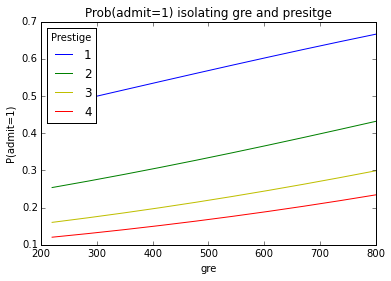

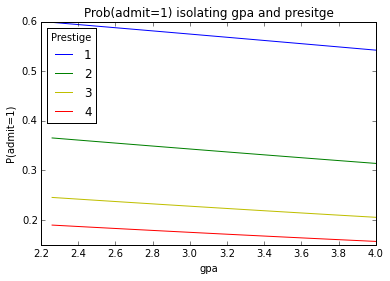

In [20]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                            aggfunc=np.mean)
    
    # in case you're curious as to what this looks like
    # print grouped.head()
    #                      admit_pred
    # gre        prestige            
    # 220.000000 1           0.282462
    #            2           0.169987
    #            3           0.096544
    #            4           0.079859
    # 284.444444 1           0.311718
    
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'],
                color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and presitge")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')